# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [354]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from joblib import parallel_backend

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [355]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\kp6829\AppData\Local\Temp\ipykernel_65236\2693282953.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
C:\Users\kp6829\AppData\Local\Temp\ipykernel_65236\2693282953.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')


In [356]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [357]:
# Look at shape of General Population df
print('General population dataframe has {} observations and {} variables.'.format(azdias.shape[0], azdias.shape[1]))

General population dataframe has 891221 observations and 366 variables.


In [358]:
# Look at shape of Customers df
print('Customer dataframe has {} observations and {} variables.'.format(customers.shape[0], customers.shape[1]))

Customer dataframe has 191652 observations and 369 variables.


In [359]:
azdias.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  8.912210e+05  891221.000000  817722.000000  817722.000000   
mean   6.372630e+05      -0.358435       4.421928      10.864126   
std    2.572735e+05       1.198724       3.638805       7.639683   
min    1.916530e+05      -1.000000       1.000000       0.000000   
25%    4.144580e+05      -1.000000       1.000000       0.000000   
50%    6.372630e+05      -1.000000       3.000000      13.000000   
75%    8.600680e+05      -1.000000       9.000000      17.000000   
max    1.082873e+06       3.000000       9.000000      21.000000   

        ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  81058.000000  29499.000000  6170.000000  1205.000000   
mean      11.745392     13.402658    14.476013    15.089627   
std        4.097660      3.243300     2.712427     2.452932   
min        2.000000      2.000000     4.000000     7.000000   
25%        8.000000     11.000000    13.000000    14.000000   
50%       12.000000     14.000000    15.000000    15.000000   
75%       15.000000     16.000000    17.000000    17.000000   
max       18.000000     18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...            VHN  \
count         628274.000000        798073.000000  ...  770025.000000   
mean              13.700717             8.287263  ...       2.417322   
std                5.079849            15.628087  ...       1.166572   
min                0.000000             0.000000  ...       0.000000   
25%               11.000000             1.000000  ...       2.000000   
50%               14.000000             4.000000  ...       2.000000   
75%               17.000000             9.000000  ...       3.000000   
max               25.000000           595.000000  ...       4.000000   

            VK_DHT4A     VK_DISTANZ        VK_ZG11  W_KEIT_KIND_HH  \
count  815304.000000  815304.000000  815304.000000   783619.000000   
mean        6.001214       7.532130       5.945972        3.933406   
std         2.856091       3.247789       2.771464        1.964701   
min         1.000000       1.000000       1.000000        0.000000   
25%         3.000000       5.000000       4.000000        2.000000   
50%         6.000000       8.000000       6.000000        4.000000   
75%         9.000000      10.000000       8.000000        6.000000   
max        11.000000      13.000000      11.000000        6.000000   

       WOHNDAUER_2008       WOHNLAGE       ZABEOTYP      ANREDE_KZ  \
count   817722.000000  798073.000000  891221.000000  891221.000000   
mean         7.908791       4.052836       3.362438       1.522098   
std          1.923137       1.949539       1.352704       0.499512   
min          1.000000       0.000000       1.000000       1.000000   
25%          8.000000       3.000000       3.000000       1.000000   
50%          9.000000       3.000000       3.000000       2.000000   
75%          9.000000       5.000000       4.000000       2.000000   
max          9.000000       8.000000       6.000000       2.000000   

       ALTERSKATEGORIE_GROB  
count         891221.000000  
mean               2.777398  
std                1.068775  
min                1.000000  
25%                2.000000  
50%                3.000000  
75%                4.000000  
max                9.000000  

[8 rows x 360 columns]

In [360]:
customers.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  191652.000000  191652.000000  145056.000000  145056.000000   
mean    95826.500000       0.344359       1.747525      11.352009   
std     55325.311233       1.391672       1.966334       6.275026   
min         1.000000      -1.000000       1.000000       0.000000   
25%     47913.750000      -1.000000       1.000000       8.000000   
50%     95826.500000       0.000000       1.000000      11.000000   
75%    143739.250000       2.000000       1.000000      16.000000   
max    191652.000000       3.000000       9.000000      21.000000   

        ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  11766.000000  5100.000000  1275.000000   236.000000   
mean      12.337243    13.672353    14.647059    15.377119   
std        4.006050     3.243335     2.753787     2.307653   
min        2.000000     2.000000     5.000000     8.000000   
25%        9.000000    11.000000    13.000000    14.000000   
50%       13.000000    14.000000    15.000000    16.000000   
75%       16.000000    16.000000    17.000000    17.000000   
max       18.000000    18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...       VK_DHT4A  \
count         139810.000000        141725.000000  ...  143781.000000   
mean              10.331579             4.965863  ...       4.374417   
std                4.134828            14.309694  ...       2.924355   
min                0.000000             0.000000  ...       1.000000   
25%                9.000000             1.000000  ...       2.000000   
50%               10.000000             1.000000  ...       4.000000   
75%               13.000000             4.000000  ...       7.000000   
max               25.000000           523.000000  ...      11.000000   

          VK_DISTANZ        VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
count  143781.000000  143781.000000   137910.000000   145056.000000   
mean        4.564769       3.168868        4.152716        8.646371   
std         2.887035       2.233516        1.974375        1.154001   
min         1.000000       1.000000        0.000000        1.000000   
25%         2.000000       1.000000        2.000000        9.000000   
50%         4.000000       3.000000        5.000000        9.000000   
75%         7.000000       4.000000        6.000000        9.000000   
max        13.000000      11.000000        6.000000        9.000000   

            WOHNLAGE       ZABEOTYP  ONLINE_PURCHASE      ANREDE_KZ  \
count  141725.000000  191652.000000    191652.000000  191652.000000   
mean        3.723133       2.576806         0.090247       1.376432   
std         2.095540       1.168486         0.286536       0.484492   
min         0.000000       1.000000         0.000000       1.000000   
25%         2.000000       1.000000         0.000000       1.000000   
50%         3.000000       3.000000         0.000000       1.000000   
75%         5.000000       3.000000         0.000000       2.000000   
max         8.000000       6.000000         1.000000       2.000000   

       ALTERSKATEGORIE_GROB  
count         191652.000000  
mean               3.060907  
std                1.086254  
min                1.000000  
25%                3.000000  
50%                3.000000  
75%                4.000000  
max                9.000000  

[8 rows x 361 columns]

## Data Cleaning

#### Remove Extra Columns

In [361]:
set(customers.columns).difference(set(azdias.columns))

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [362]:
# Remove extra columns from customers dataset
extra_columns = list(set(customers.columns).difference(set(azdias.columns)))
customers.drop(extra_columns, axis=1, inplace=True)

#### Read in information on the attributes, derived from DIAS Attributes Values 2017.xlxs

In [363]:
attributes = pd.read_csv('attributes.csv', sep=';', names = ['Attribute','Type','Unknown_Values']) 
attributes.head()

Attribute         Type Unknown_Values
0              AGER_TYP  categorical         [-1,0]
1  ALTERSKATEGORIE_FEIN      ordinal       [-1,0.9]
2  ALTERSKATEGORIE_GROB      ordinal       [-1,0,9]
3              ALTER_HH      ordinal            [0]
4             ANREDE_KZ  categorical         [-1,0]

In [364]:
unknowns = pd.Series(attributes['Unknown_Values'].values, index=attributes['Attribute'])

In [365]:
azdias_columns_not_described = list(set(azdias) - set(attributes['Attribute'].tolist()))

In [366]:
azdias_columns_not_described

['EXTSEL992',
 'D19_LETZTER_KAUF_BRANCHE',
 'VK_DISTANZ',
 'RT_SCHNAEPPCHEN',
 'UMFELD_JUNG',
 'KOMBIALTER',
 'VK_ZG11',
 'VHN',
 'CJT_TYP_1',
 'STRUKTURTYP',
 'CJT_TYP_6',
 'EINGEFUEGT_AM',
 'UMFELD_ALT',
 'ALTER_KIND2',
 'AKT_DAT_KL',
 'CJT_KATALOGNUTZER',
 'LNR',
 'GEMEINDETYP',
 'ALTER_KIND4',
 'CJT_TYP_3',
 'CJT_TYP_2',
 'VERDICHTUNGSRAUM',
 'CJT_TYP_4',
 'ALTER_KIND1',
 'D19_KONSUMTYP_MAX',
 'RT_UEBERGROESSE',
 'VHA',
 'ALTER_KIND3',
 'RT_KEIN_ANREIZ',
 'FIRMENDICHTE',
 'VK_DHT4A',
 'CJT_TYP_5']

#### Remove columns not described

In [367]:
azdias = azdias.drop(labels=azdias_columns_not_described, axis=1)
customers = customers.drop(labels=azdias_columns_not_described, axis=1)

In [368]:
def preprocess_data(df, unknowns):
    """
    Preprocesses the input DataFrame by replacing the unknown values with NaNs and
    converting integer columns to float data type, excluding the 'RESPONSE' column.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame to preprocess.

    unknowns : pandas.Series
        A Series containing the unknown values for each column in the DataFrame.
        The index of the Series should be the column names.

    Returns
    -------
    df : pandas.DataFrame
        The preprocessed DataFrame with unknown values replaced by NaNs and integer
        columns converted to float data type.
    """
    for column in df.columns:
        if column != 'RESPONSE':
            if df[column].dtype == np.int64:
                df[column] = df[column].astype(np.float64)

            isin = ast.literal_eval(unknowns[column])
            df[column] = df[column].mask(df[column].isin(isin), other=np.nan)

    return df

In [369]:
azdias = preprocess_data(azdias, unknowns)
customers = preprocess_data(customers, unknowns)

#### Feature engineer

In [370]:
def feature_engineer(df):
    """
    Performs feature engineering on the input DataFrame by creating new and more
    informative features from existing ones.
    
    - CAMEO_INTL_2015 splits into CAMEO_INTL_FAM_STATUS and CAMEO_INTL_FAM_COMPOSITION.
    - PRAEGENDE_JUGENDJAHRE splits into YOUTH_DECADE and AVANT_GARDE.
    - Simplifies ALTER_HH to represent decades.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame to be transformed.

    Returns
    -------
    df : pandas.DataFrame
        The transformed DataFrame with new and updated features.
    """
    # Creating CAMEO_INTL_FAM_STATUS feature (first digit of CAMEO_INTL_2015)
    df['CAMEO_INTL_FAM_STATUS'] = df['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[0]) if not pd.isnull(x) else np.nan)

    # Creating CAMEO_INTL_FAM_COMPOSITION feature (second digit of CAMEO_INTL_2015)
    df['CAMEO_INTL_FAM_COMPOSITION'] = df['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[1]) if not pd.isnull(x) else np.nan)

    # Creating YOUTH_DECADE feature based on PRAEGENDE_JUGENDJAHRE
    youth_decade_mapping = {1: 4, 2: 4, 3: 5, 4: 5, 5: 6, 6: 6, 7: 6, 8: 7, 9: 7, 10: 8, 11: 8, 12: 8, 13: 8, 14: 9, 15: 9}
    df['YOUTH_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(youth_decade_mapping)

    # Creating AVANT_GARDE feature based on PRAEGENDE_JUGENDJAHRE
    avant_garde_mapping = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1}
    df['AVANT_GARDE'] = df['PRAEGENDE_JUGENDJAHRE'].map(avant_garde_mapping)

    # Deleting original columns
    df.drop(columns=['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], inplace=True)

    # Simplifying ALTER_HH to represent decades
    alter_hh_mapping = {1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 6, 13: 6, 14: 7, 15: 7, 16: 8, 17: 8, 18: 9, 19: 9}
    df['ALTER_HH'] = df['ALTER_HH'].map(alter_hh_mapping)

    return df

In [371]:
azdias = feature_engineer(azdias)
customers = feature_engineer(customers)

C:\Users\kp6829\AppData\Local\Temp\ipykernel_65236\1180879290.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CAMEO_INTL_FAM_STATUS'] = df['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[0]) if not pd.isnull(x) else np.nan)
C:\Users\kp6829\AppData\Local\Temp\ipykernel_65236\1180879290.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CAMEO_INTL_FAM_COMPOSITION'] = df['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[1]) if not pd.isnull(x) else np.nan)
C:\Users\kp6829\AppData\Local\Temp\ipykernel_65236\1180879290.py:28

#### Find columns with a lot of nulls

In [372]:
def null_percentages_distribution(df):
    """
    Calculates the percentage of missing values (null values) in each column of the input DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame for which the percentage of missing values in each column will be calculated.

    Returns
    -------
    null_percentages : dict
        A dictionary with column names as keys and the percentage of missing values in the corresponding column as values.
    """
    null_percentages = {}
    
    for column in df.columns:
        null_count = df[column].isna().sum()
        null_percentage = (null_count / len(df)) * 100
        null_percentages[column] = null_percentage

    return null_percentages

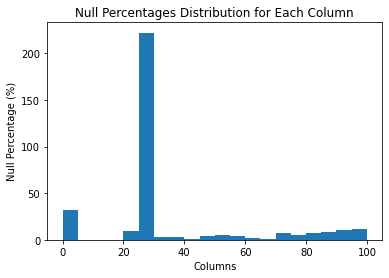

In [373]:
null_distribution = null_percentages_distribution(customers)

# Plot the distribution
columns = list(null_distribution.keys())
percentages = list(null_distribution.values())

plt.hist(percentages, bins = 20)
plt.xlabel('Columns')
plt.ylabel('Null Percentage (%)')
plt.title('Null Percentages Distribution for Each Column')
plt.show()

In [374]:
#look at nulls

def find_columns_with_nulls(df, threshold):
    columns_with_high_nulls = []
    
    for column in df.columns:
        null_count = df[column].isna().sum()
        null_percentage = (null_count / len(df)) * 100
        
        if null_percentage > threshold:
            columns_with_high_nulls.append((column, null_percentage))
    
    return columns_with_high_nulls


In [375]:
null_result_customers = find_columns_with_nulls(customers, 30)
for column, percentage in null_result_customers:
    print(f"{column}: {percentage}%")

AGER_TYP: 50.47586250078267%
ALTER_HH: 43.72717216621794%
D19_BANKEN_ANZ_12: 93.99849727631332%
D19_BANKEN_ANZ_24: 90.63354413207271%
D19_BANKEN_DATUM: 79.70801243921274%
D19_BANKEN_DIREKT: 86.99413520338948%
D19_BANKEN_GROSS: 91.34472898795734%
D19_BANKEN_LOKAL: 97.75374115584496%
D19_BANKEN_OFFLINE_DATUM: 96.11274601882579%
D19_BANKEN_ONLINE_DATUM: 87.44234341410473%
D19_BANKEN_ONLINE_QUOTE_12: 96.45503308079228%
D19_BANKEN_REST: 91.95990649719283%
D19_BEKLEIDUNG_GEH: 80.48024544486883%
D19_BEKLEIDUNG_REST: 71.92619957005407%
D19_BILDUNG: 81.2655229269718%
D19_BIO_OEKO: 91.07236031974621%
D19_BUCH_CD: 53.710370880554336%
D19_DIGIT_SERV: 95.76680650345418%
D19_DROGERIEARTIKEL: 83.92137833155928%
D19_ENERGIE: 90.22394757164027%
D19_FREIZEIT: 86.80472940538058%
D19_GARTEN: 93.9040552668378%
D19_GESAMT_ANZ_12: 58.43873270302423%
D19_GESAMT_ANZ_24: 47.858618746477994%
D19_GESAMT_DATUM: 31.58641704756538%
D19_GESAMT_OFFLINE_DATUM: 46.592782752071464%
D19_GESAMT_ONLINE_DATUM: 46.87663055955

In [376]:
null_result_azdias = find_columns_with_nulls(azdias, 30)
for column, percentage in null_result_azdias:
    print(f"{column}: {percentage}%")

AGER_TYP: 76.95543529607134%
ALTER_HH: 44.046089578230315%
D19_BANKEN_ANZ_12: 93.32522460758892%
D19_BANKEN_ANZ_24: 89.10247850981968%
D19_BANKEN_DATUM: 76.11254671961277%
D19_BANKEN_DIREKT: 81.77668614182116%
D19_BANKEN_GROSS: 88.1207915881695%
D19_BANKEN_LOKAL: 98.15130029476416%
D19_BANKEN_OFFLINE_DATUM: 97.79112027207617%
D19_BANKEN_ONLINE_DATUM: 81.5714620728192%
D19_BANKEN_ONLINE_QUOTE_12: 94.92449123169226%
D19_BANKEN_REST: 92.20608580812166%
D19_BEKLEIDUNG_GEH: 90.80845267335486%
D19_BEKLEIDUNG_REST: 77.70261248332343%
D19_BILDUNG: 91.24066870058044%
D19_BIO_OEKO: 95.83189803651395%
D19_BUCH_CD: 69.88031027096534%
D19_DIGIT_SERV: 96.23437957588521%
D19_DROGERIEARTIKEL: 85.39004354699901%
D19_ENERGIE: 93.11461466908881%
D19_FREIZEIT: 88.72636528986637%
D19_GARTEN: 95.55721869210892%
D19_GESAMT_ANZ_12: 65.61750676880371%
D19_GESAMT_ANZ_24: 56.69783364619999%
D19_GESAMT_DATUM: 39.739862503239934%
D19_GESAMT_OFFLINE_DATUM: 62.673343648769496%
D19_GESAMT_ONLINE_DATUM: 50.60417113151

In [377]:
columns_to_drop = [x[0] for x in null_result_customers]

In [378]:
customers = customers.drop(columns_to_drop, axis = 1)
azdias = azdias.drop(columns_to_drop, axis = 1)

#### Find rows with a lot of nulls

In [379]:
def find_rows_with_nulls(df, threshold):
    """
    Identifies rows in the input DataFrame with a percentage of missing values (null values) above the specified threshold.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame for which rows with a high percentage of missing values will be identified.

    threshold : float
        The percentage threshold for identifying rows with a high percentage of missing values.

    Returns
    -------
    rows_with_high_nulls : list of tuples
        A list of tuples, where each tuple contains the index of a row with a high percentage of missing values and
        the corresponding percentage of missing values.
    """
    rows_with_high_nulls = []
    
    for index, row in df.iterrows():
        null_count = row.isna().sum()
        null_percentage = (null_count / len(row)) * 100
         
        if null_percentage > threshold:
            rows_with_high_nulls.append((index, null_percentage))
    
    return rows_with_high_nulls

In [380]:
threshold = 50  # Set the threshold percentage
result_azdias = find_rows_with_nulls(azdias, threshold)
print("Rows with null percentage above the threshold:")
for row_index, percentage in result_azdias:
    print(f"Row {row_index}: {percentage}%")

Rows with null percentage above the threshold:
Row 0: 86.31178707224335%
Row 11: 87.83269961977186%
Row 14: 87.83269961977186%
Row 17: 87.83269961977186%
Row 24: 87.83269961977186%
Row 26: 72.6235741444867%
Row 30: 80.98859315589354%
Row 35: 86.31178707224335%
Row 46: 83.26996197718631%
Row 48: 87.83269961977186%
Row 53: 86.31178707224335%
Row 54: 87.83269961977186%
Row 61: 86.31178707224335%
Row 62: 86.31178707224335%
Row 69: 87.83269961977186%
Row 73: 68.8212927756654%
Row 75: 87.83269961977186%
Row 76: 86.31178707224335%
Row 81: 87.07224334600761%
Row 83: 86.31178707224335%
Row 90: 80.98859315589354%
Row 97: 87.83269961977186%
Row 99: 87.83269961977186%
Row 103: 87.83269961977186%
Row 106: 86.31178707224335%
Row 108: 87.83269961977186%
Row 109: 86.31178707224335%
Row 112: 87.83269961977186%
Row 133: 87.83269961977186%
Row 137: 87.83269961977186%
Row 138: 76.80608365019012%
Row 142: 72.24334600760456%
Row 143: 72.6235741444867%
Row 144: 87.83269961977186%
Row 153: 86.31178707224335%


In [381]:
len(result_azdias) / len(azdias)

0.11244461250352045

In [382]:
rows_to_drop = [x[0] for x in result_azdias]
azdias = azdias.drop(rows_to_drop, axis = 0)

In [383]:
threshold = 50  # Set the threshold percentage
result_customers = find_rows_with_nulls(customers, threshold)
print("Rows with null percentage above the threshold:")
for row_index, percentage in result_customers:
    print(f"Row {row_index}: {percentage}%")

Rows with null percentage above the threshold:
Row 1: 85.17110266159695%
Row 10: 80.22813688212928%
Row 36: 87.83269961977186%
Row 37: 87.83269961977186%
Row 38: 87.83269961977186%
Row 39: 87.83269961977186%
Row 40: 87.83269961977186%
Row 43: 87.83269961977186%
Row 44: 87.83269961977186%
Row 46: 87.83269961977186%
Row 51: 87.83269961977186%
Row 53: 87.83269961977186%
Row 54: 87.83269961977186%
Row 55: 87.83269961977186%
Row 56: 87.83269961977186%
Row 58: 87.83269961977186%
Row 59: 87.83269961977186%
Row 60: 87.83269961977186%
Row 62: 87.83269961977186%
Row 67: 87.83269961977186%
Row 68: 87.83269961977186%
Row 69: 87.83269961977186%
Row 71: 87.83269961977186%
Row 72: 87.83269961977186%
Row 84: 87.83269961977186%
Row 85: 87.83269961977186%
Row 87: 87.83269961977186%
Row 89: 87.83269961977186%
Row 90: 87.83269961977186%
Row 91: 87.83269961977186%
Row 92: 87.83269961977186%
Row 94: 87.83269961977186%
Row 100: 87.83269961977186%
Row 101: 87.83269961977186%
Row 105: 87.83269961977186%
Row 10

In [384]:
len(result_customers) / len(customers)

0.26515768163129005

In [385]:
rows_to_drop = [x[0] for x in result_customers]
customers = customers.drop(rows_to_drop, axis = 0)

In [386]:
def remove_non_informative_columns(df):
    """
    Removes non-informative columns from the input DataFrame. A column is considered non-informative
    if it has only one unique value (excluding NaN values).

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame from which non-informative columns will be removed.

    Returns
    -------
    df : pandas.DataFrame
        The transformed DataFrame with non-informative columns removed.
    """
    informative_columns = []
    
    for column in df.columns:
        unique_values = df[column].nunique(dropna=True)
         
        if unique_values > 1:
            informative_columns.append(column)
        else:
            print(f"Removed non-informative column: {column}")

    return df[informative_columns]

In [387]:
customers = remove_non_informative_columns(customers)
azdias = remove_non_informative_columns(azdias)

#### Look at columns with mixed variable types

In [388]:
mixed_attributes = attributes['Attribute'].loc[attributes['Type'] == 'mixed']

In [389]:
mixed_attributes

15           CAMEO_INTL_2015
289      LP_LEBENSPHASE_FEIN
290      LP_LEBENSPHASE_GROB
307    PRAEGENDE_JUGENDJAHRE
Name: Attribute, dtype: object

## Exploratory Data Analysis

In [391]:
def customers_against_general(column_name, customers_df, general_df):
    """
    Compares the distribution of a categorical feature in the customers dataset against the general population dataset.
    Plots a bar chart to visualize the percentage of each category in both datasets.

    Parameters
    ----------
    column_name : str
        The name of the categorical column to compare.

    customers_df : pandas.DataFrame
        The customers dataset DataFrame.

    general_df : pandas.DataFrame
        The general population dataset DataFrame.

    Returns
    -------
    None
    """
    # Counting customers observations for each category
    customers_counts = customers_df[column_name].value_counts()

    # Counting general population observations for each category
    general_counts = general_df[column_name].value_counts().sort_index()

    # Creating DataFrame
    comparison_df = pd.DataFrame(index=general_counts.index.values, columns=['customers_count', 'general_count', 'customers_percentage', 'general_population_percentage'])
    comparison_df.general_count = general_counts.values

    # Assigning values to customers column
    comparison_df.customers_count = [customers_counts[customers_counts.index == idx].values[0] if len(customers_counts[customers_counts.index == idx].values) == 1 else 0 for idx in comparison_df.index.values]

    # Computing each category's percentage
    comparison_df.customers_percentage = (comparison_df.customers_count / np.sum(comparison_df.customers_count)) * 100
    comparison_df.general_population_percentage = (comparison_df.general_count / np.sum(comparison_df.general_count)) * 100

    # Plotting bar plot using matplotlib
    indices = np.arange(len(comparison_df.index))
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    customers_bars = ax.bar(indices - bar_width / 2, comparison_df.customers_percentage, bar_width, label='Customers')
    general_bars = ax.bar(indices + bar_width / 2, comparison_df.general_population_percentage, bar_width, label='General Population')

    ax.set_xlabel('Category')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Customers Vs. General Population - "{column_name}"')
    ax.set_xticks(indices)
    ax.set_xticklabels(comparison_df.index)
    ax.legend()

    plt.show()

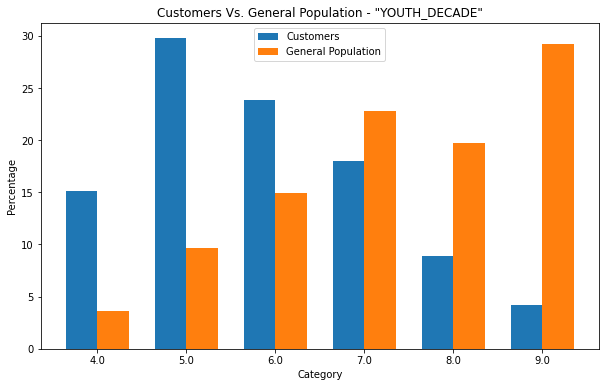

In [392]:
customers_against_general('YOUTH_DECADE', customers_df=customers, general_df=azdias)

By comparing proportions, we can see that the customers are much more likely to have their youth decade in the 40s, 50s, and 60s, meaning the customer base is generally older than the general population

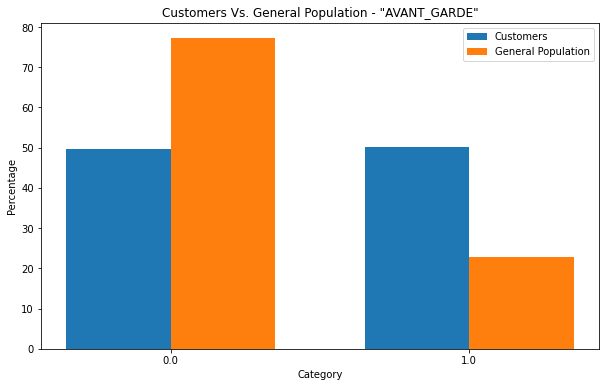

In [393]:
customers_against_general('AVANT_GARDE', customers_df=customers, general_df=azdias)

We can see that the customers are much more likely to be avant garde

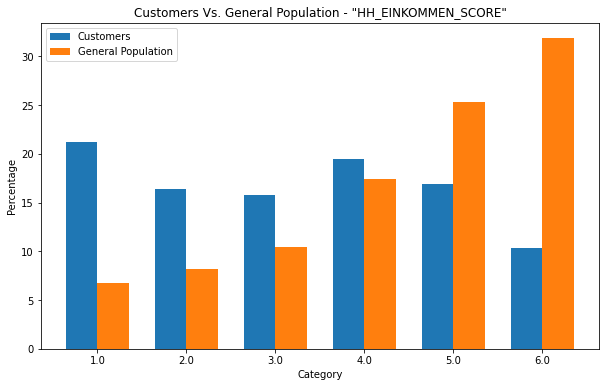

In [394]:
customers_against_general('HH_EINKOMMEN_SCORE', customers_df=customers, general_df=azdias)

We can see that customers are way more likely to have values of 1, 2, and 3, which correspond with highest, very high, and high income, respectively. 

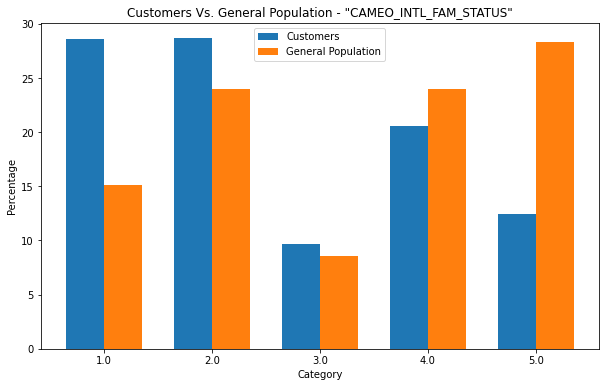

In [395]:
customers_against_general('CAMEO_INTL_FAM_STATUS', customers_df=customers, general_df=azdias)

Again, customers seem much more likely to have values of 1 and 2, indicating wealthy and prosperous.

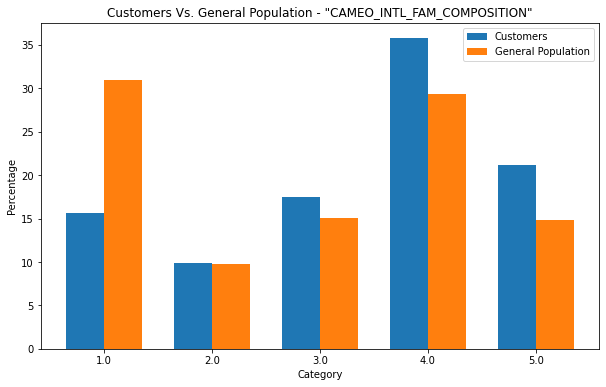

In [396]:
customers_against_general('CAMEO_INTL_FAM_COMPOSITION', customers_df=customers, general_df=azdias)

An interesting finding is that customers are much less likely to be pre-families and singles and much more likely to be older families/mature couples as well as elders in retirement

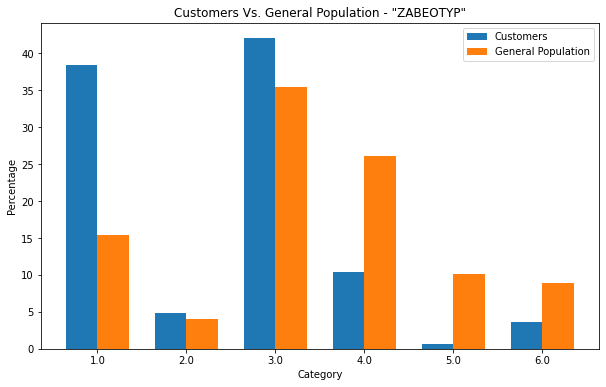

In [397]:
customers_against_general('ZABEOTYP', customers_df=customers, general_df=azdias)

Customers tend to be more green and fair supplied than the general population

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [398]:
customers.shape

(140834, 263)

In [399]:
azdias.shape

(791008, 263)

In [400]:
# Identify categorical and numerical columns
categorical_columns = azdias.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = azdias.select_dtypes(include=['number']).columns.tolist()

# Convert all categorical columns to string data type
azdias[categorical_columns] = azdias[categorical_columns].astype(str)
customers[categorical_columns] = customers[categorical_columns].astype(str)

# Define preprocessor pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_columns),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_columns)
])

In [401]:
# Preprocess the azdias dataset
azdias_preprocessed = preprocessor.fit_transform(azdias)

# Preprocess the customers dataset using the same preprocessor
customers_preprocessed = preprocessor.transform(customers)

In [402]:
azdias.shape

(791008, 263)

In [403]:
customers.shape

(140834, 263)

In [404]:
pca = PCA(n_components=0.95)  # Retain 95% of the explained variance
azdias_pca = pca.fit_transform(azdias_preprocessed)

# Apply the same PCA transformation to the customers dataset
customers_pca = pca.transform(customers_preprocessed)

In [405]:
# Take a random sample of the data
sample_size = 10000
azdias_pca_sample = shuffle(azdias_pca, random_state=42, n_samples=sample_size)

# Determine the optimal number of clusters using the Elbow Method and Silhouette Coefficient
inertia = []
silhouette = []

with parallel_backend('threading', n_jobs=-1):
    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(azdias_pca_sample)
        
        inertia.append(kmeans.inertia_)
        silhouette.append(silhouette_score(azdias_pca_sample, cluster_labels))


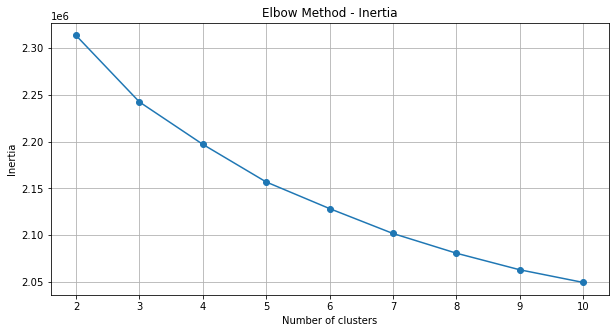

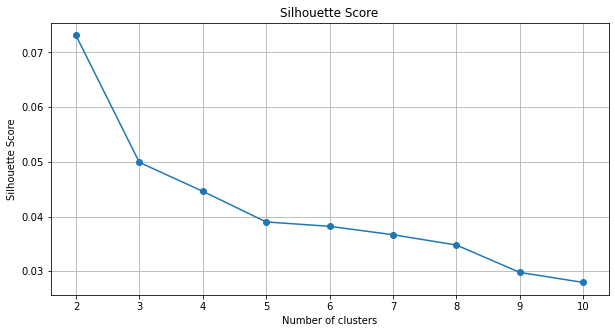

In [406]:
n_clusters_range = list(range(2, 11))

# Plot Inertia
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method - Inertia')
plt.grid()
plt.show()

# Plot Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, silhouette, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.grid()
plt.show()

In [407]:
# Fit the clustering model using the optimal number of clusters
optimal_clusters =  5# Choose the optimal number of clusters based on your analysis
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
azdias_cluster_assignments = kmeans.fit_predict(azdias_pca)

# Predict cluster assignments for the customer dataset
customers_cluster_assignments = kmeans.predict(customers_pca)

# Analyze the results
azdias_cluster_counts = np.bincount(azdias_cluster_assignments)
customers_cluster_counts = np.bincount(customers_cluster_assignments)

# Normalize the counts to get proportions
azdias_cluster_proportions = azdias_cluster_counts / len(azdias_pca)
customers_cluster_proportions = customers_cluster_counts / len(customers_pca)

# Compare the distributions
cluster_comparison = pd.DataFrame({'Azdias': azdias_cluster_proportions, 'Customers': customers_cluster_proportions})
print(cluster_comparison)

     Azdias  Customers
0  0.298592   0.396382
1  0.240876   0.109917
2  0.158916   0.074073
3  0.175868   0.380462
4  0.125747   0.039167


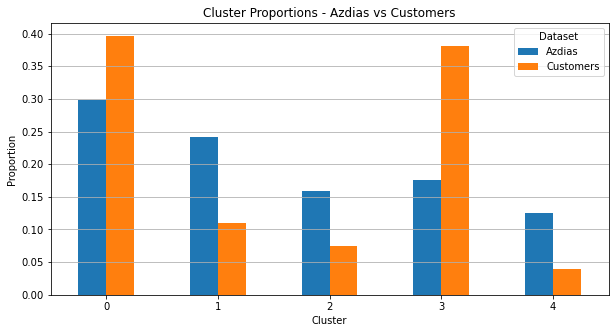

In [408]:
# Plot the bar chart
ax = cluster_comparison.plot.bar(figsize=(10, 5), rot=0)
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.title('Cluster Proportions - Azdias vs Customers')
plt.legend(title='Dataset')
plt.grid(axis='y')
plt.show()

In [409]:
azdias_preprocessed_df = pd.DataFrame(azdias_preprocessed, columns=numerical_columns + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_columns)))
customers_preprocessed_df = pd.DataFrame(customers_preprocessed, columns=numerical_columns + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_columns)))

In [410]:
# Calculate the relative difference between customer and general population cluster proportions
relative_difference = (cluster_comparison['Customers'] - cluster_comparison['Azdias']) / cluster_comparison['Azdias']

# Identify overrepresented and underrepresented clusters
overrepresented_clusters = relative_difference[relative_difference > 0].index.tolist()
underrepresented_clusters = relative_difference[relative_difference < 0].index.tolist()

# Print the results
print("Overrepresented clusters in the customer dataset:", overrepresented_clusters)
print("Underrepresented clusters in the customer dataset:", underrepresented_clusters)

Overrepresented clusters in the customer dataset: [0, 3]
Underrepresented clusters in the customer dataset: [1, 2, 4]


In [411]:
def get_important_features(pca, kmeans, azdias_preprocessed_df, n_top_features=5):
    pca_centroids = pca.inverse_transform(kmeans.cluster_centers_)
    important_features = []

    # Calculate the mean of all data points
    dataset_mean = azdias_preprocessed_df.mean(axis=0)

    for cluster_idx, centroid in enumerate(pca_centroids):
        # Calculate the difference between the centroid and the dataset mean
        feature_differences = centroid - dataset_mean

        # Get the top N features with the largest absolute differences
        top_n_feature_indices = np.argsort(np.abs(feature_differences))[-n_top_features:][::-1]
        top_features_in_cluster = [(azdias_preprocessed_df.columns[idx], feature_differences[idx]) for idx in top_n_feature_indices]

        important_features.append((cluster_idx, top_features_in_cluster))

    return important_features


# Get the most important features for each cluster
important_features_by_cluster = get_important_features(pca, kmeans, azdias_preprocessed_df)

# Print the results
for cluster_idx, features in important_features_by_cluster:
    print(f"Cluster {cluster_idx}:")
    for feature, difference in features:
        print(f"  {feature}: {difference}")
    print()

Cluster 0:
  KBA13_ANTG3: -0.8955553671464281
  PLZ8_ANTG3: -0.8718391978837239
  MOBI_RASTER: 0.85144023981929
  MOBI_REGIO: 0.8423154496429742
  EWDICHTE: -0.8386563593149189

Cluster 1:
  HH_EINKOMMEN_SCORE: 0.6365715244890028
  LP_STATUS_FEIN: -0.6344123914592097
  LP_STATUS_GROB: -0.6281916075548486
  MOBI_REGIO: -0.5382394802291797
  MOBI_RASTER: -0.523595079534917

Cluster 2:
  PLZ8_BAUMAX: 1.5972691425660637
  KBA13_BAUMAX: 1.5883324868593625
  KBA13_ANTG4: 1.3459965467881236
  PLZ8_ANTG4: 1.3262563420762072
  KBA13_AUTOQUOTE: -1.2717137735214303

Cluster 3:
  KBA13_HERST_BMW_BENZ: 0.897384556664242
  GREEN_AVANTGARDE: 0.8706505941651134
  AVANT_GARDE: 0.870650594165113
  KBA05_KW3: 0.837190560906148
  KBA13_SEG_SPORTWAGEN: 0.8238533366881425

Cluster 4:
  KBA13_SITZE_5: 1.585106113671432
  KBA13_SITZE_4: -1.4805858954312765
  KBA13_HERST_BMW_BENZ: -1.4396705644087109
  KBA13_MERCEDES: -1.3778298897414691
  KBA13_SEG_OBEREMITTELKLASSE: -1.357212424509027



Findings:

Customers are overrepresented in clusters 0 and 3.
The top features in cluster 0 are:
KBA13_ANTG3, PLZ8_ANTG3, MOBI_RASTER, MOBI_REGIO, and MOBI_RASTER


By far the most overrepresente cluster is cluster 3.
The top features in cluster 3 are:
KBA13_HERST_BMW_BENZ, GREEN_AVANTGARDE, AVANT_GARDE, KBA05_KW3, and KBA13_SEG_SPORTWAGEN

The results of this clustering reinforces the findings from the EDA in that customes are avant garde and green. Some additional insights seem to be that customers are much more likely to own sports cars, BMWs, and cars with high engine power. This is an extremely valuable insight when targeting future customers. The company should look at people who own expensive, luxury sports cars, perhaps partnering with a car dealership.


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [412]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\kp6829\AppData\Local\Temp\ipykernel_65236\3492614913.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [413]:
mailout_train.shape

(42962, 367)

In [414]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\kp6829\AppData\Local\Temp\ipykernel_65236\137136989.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [415]:
mailout_test.shape

(42833, 366)

In [416]:
set(mailout_train.columns).difference(set(mailout_test.columns))

{'RESPONSE'}

## Clean the data using the cleaning functions defined above

In [417]:
mailout_train = mailout_train.drop(labels=azdias_columns_not_described, axis=1)
mailout_test = mailout_test.drop(labels=azdias_columns_not_described, axis=1)

mailout_train = preprocess_data(mailout_train, unknowns)
mailout_test = preprocess_data(mailout_test, unknowns)

mailout_train = feature_engineer(mailout_train)
mailout_test = feature_engineer(mailout_test)

null_result_train = find_columns_with_nulls(mailout_train, 30)
columns_to_drop = [x[0] for x in null_result_train]

mailout_train = mailout_train.drop(columns_to_drop, axis = 1)
mailout_test = mailout_test.drop(columns_to_drop, axis = 1)

result_train = find_rows_with_nulls(mailout_train, threshold)

rows_to_drop = [x[0] for x in result_train]
mailout_train = mailout_train.drop(rows_to_drop, axis = 0)

result_test = find_rows_with_nulls(mailout_test, threshold)

rows_to_drop = [x[0] for x in result_test]
mailout_test = mailout_test.drop(rows_to_drop, axis = 0)

mailout_train = remove_non_informative_columns(mailout_train)
mailout_test = remove_non_informative_columns(mailout_test)

C:\Users\kp6829\AppData\Local\Temp\ipykernel_65236\1180879290.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CAMEO_INTL_FAM_STATUS'] = df['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[0]) if not pd.isnull(x) else np.nan)
C:\Users\kp6829\AppData\Local\Temp\ipykernel_65236\1180879290.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CAMEO_INTL_FAM_COMPOSITION'] = df['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[1]) if not pd.isnull(x) else np.nan)
C:\Users\kp6829\AppData\Local\Temp\ipykernel_65236\1180879290.py:28

In [418]:
mailout_train.shape

(35092, 267)

In [419]:
mailout_test.shape

(35096, 266)

In [420]:
mailout_train['RESPONSE'].value_counts()

0    34656
1      436
Name: RESPONSE, dtype: int64

In [421]:
# Identify categorical columns
categorical_columns = mailout_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [422]:
mailout_train[categorical_columns] = mailout_train[categorical_columns].astype(str)
mailout_test[categorical_columns] = mailout_test[categorical_columns].astype(str)

In [423]:


# Separate features and target variable
X = mailout_train.drop('RESPONSE', axis=1)
y = mailout_train['RESPONSE']

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = X.select_dtypes(include=['number']).columns.tolist()

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), numerical_columns),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_columns)
])

# Define the pipeline for rebalancing and training the model
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the grid of hyperparameters and models for evaluation
param_grid = [
    {
        'classifier': [LogisticRegression(random_state=42)],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    }
]

# Perform a grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=cv, n_jobs=1, verbose=2)
grid_search.fit(X, y)

# Print the best model and its performance
print("Best model:", grid_search.best_estimator_)
print("Best ROC-AUC score:", grid_search.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.001; total time=   2.2s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.001; total time=   2.2s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.001; total time=   2.3s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.001; total time=   2.5s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.001; total time=   2.3s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.01; total time=   2.3s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.01; total time=   2.4s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.01; total time=   2.3s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.01; total time=   2.3s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.01; total time=   2.3s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.1; total time=   2.4s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.1; total time=   2.2s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.1; total time=   2.3s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.1; total time=   2.1s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=0.1; total time=   2.3s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=1; total time=   2.3s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=1; total time=   2.2s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=1; total time=   2.4s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=1; total time=   2.2s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=1; total time=   2.2s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=10; total time=   2.3s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=10; total time=   2.6s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=10; total time=   2.3s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=10; total time=   2.2s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=10; total time=   2.2s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=100; total time=   2.4s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=100; total time=   2.2s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=100; total time=   2.4s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=100; total time=   2.4s


C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(random_state=42), classifier__C=100; total time=   2.3s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=None, classifier__n_estimators=50; total time=  24.4s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=None, classifier__n_estimators=50; total time=  21.9s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=None, classifier__n_estimators=50; total time=  23.4s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=None, classifier__n_estimators=50; total time=  21.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=None, classifier__n_estimators=50; total time=  23.3s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=None, classifier__n_estimators=100; total time=  46.1s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth

C:\Users\kp6829\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [424]:
# Make predictions using the best estimator found by GridSearchCV
best_estimator = grid_search.best_estimator_
predictions = best_estimator.predict(mailout_test)

# Use proba to get probabilities
probabilities = best_estimator.predict_proba(mailout_test)

In [425]:
# Count the number of 1 predictions
count_ones = np.sum(predictions == 1)

# Calculate the proportion of 1 predictions
proportion_ones = count_ones / len(predictions)

# Print the proportion
print("Proportion of 1 predictions: {:.2f}".format(proportion_ones))

Proportion of 1 predictions: 0.29


After using the grid search and cross validation, we now have a reliable model to make predictions on. Therefore, we can more accurately perform the mailout campaign by targeting potential customers who are more likely to respond to the campaign.